In [ ]:
#importing necessary packages and libraries
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange

import time
from time import sleep

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import os

import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.cElementTree as et
from collections import defaultdict

In [ ]:
#mounting google drive (where the dataset is stored)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cpu'), 1)

TRAINING 

In [ ]:
## Negative
neg_subject_ids = []
neg_xml_paths = []
neg_label = []
for i in range(1,11):
  path = '/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/training_data_T1/2018_train/negative_examples/chunk'+str(i)
  dirListing = os.listdir(path)
  for item in dirListing:
    if ".xml" in item:
      neg_xml_paths.append(path+'/'+item)
      neg_subject_ids.append(item)
      neg_label.append(0)
print(len(neg_subject_ids))
print(len(neg_xml_paths))

1320
1320


In [ ]:
## Positive
pos_subject_ids = []
pos_xml_paths = []
pos_label = []
for i in range(1,11):
  path = '/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/training_data_T1/2018_train/positive_examples/chunk'+str(i)
  dirListing = os.listdir(path)
  for item in dirListing:
    if ".xml" in item:
      pos_xml_paths.append(path+'/'+item)
      pos_subject_ids.append(item)
      pos_label.append(1)
print(len(pos_subject_ids))
print(len(pos_xml_paths))

200
200


In [ ]:
#combining the data of negative and positive records
subject_ids = neg_subject_ids+pos_subject_ids
xml_paths = neg_xml_paths+pos_xml_paths
labels = neg_label+pos_label

In [ ]:
# defining a function which will clean the subject_id 
def clean_subject_id_name(name):
  clean_name = name.split("_", 1)
  return clean_name[0]


In [ ]:
for i in range(len(subject_ids)):
  clean_name = clean_subject_id_name(subject_ids[i])
  subject_ids[i] = clean_name

In [ ]:
#Making dataframe
training_df = pd.DataFrame({'Subject_IDS': subject_ids, 'XML_Paths': xml_paths, 'Ground_Truth': labels})
training_df.head()

,Subject_IDS,XML_Paths,Ground_Truth
0,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0
1,subject1120,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0
2,subject1074,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0
3,subject1143,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0
4,subject1193,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0


In [ ]:
#reading the comments from training data and adding to the training dataframe
text_data = []
for i in range(len(training_df)) :
  path = training_df.loc[i, "XML_Paths"]
  lst = []
  tree = et.parse(path) #read in the XML
  for var in tree.iter(tag = 'WRITING'):
    comment = var.find('TEXT').text
    lst.append(comment)
  text_data.append(lst)


In [ ]:
training_df['Comments'] = text_data

In [ ]:
training_df

,Subject_IDS,XML_Paths,Ground_Truth,Comments
0,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,"[ Because he saw a movie once? , It's Canadia..."
1,subject1120,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,"[ , Perfect place for a vampire to take a st..."
2,subject1074,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,"[ , https://steamuserimages-a.akamaihd.net/u..."
3,subject1143,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,"[ Once I named myself 'pros solo', the number ..."
4,subject1193,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,[ obligatory happy birthday because it's your ...
...,...,...,...,...
1515,subject6446,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,"[ God damn pumpkin spice anything... , My aun..."
1516,subject845,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,"[ In other words, how does the browser handle ..."
1517,subject3132,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,[ Anyone able to hook a sister up in the west ...
1518,subject3259,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,"[ [removed] , , Yeah! The watermelon one is..."


In [ ]:
# splitting the dataframe such that there is only one comment in each row
training_df = training_df.explode('Comments', ignore_index=True)

In [ ]:
training_df

,Subject_IDS,XML_Paths,Ground_Truth,Comments
0,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,Because he saw a movie once?
1,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,It's Canadian and was produced for dirt cheap...
2,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,World War Zimmerman and The Hobbit are probab...
3,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,dude you're the first person i've ever seen o...
4,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,...\n\n...\n\n...\n\n...lol!
...,...,...,...,...
84830,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i couldn't find it
84831,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,im so convinced that i have cancer and I'm go...
84832,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,[removed]
84833,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i LOVE being married \n\nbut i hate hate hate...


In [ ]:
#saving the dataframe as csv file
from pathlib import Path  
filepath = Path('training_df.csv') 

In [ ]:
training_df.to_csv(filepath)

VALIDATION

In [ ]:
#reading in the validation data
val_subject_ids = []
val_xml_paths = []
for i in range(1,11):
  path = '/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/training_data_T1/2018_test/chunk'+str(i)+'/chunk'+str(i)
  dirListing = os.listdir(path)
  for item in dirListing:
    if ".xml" in item:
      val_xml_paths.append(path+'/'+item)
      val_subject_ids.append(item)
print(len(val_subject_ids))
print(len(val_xml_paths))

3200
3200


In [ ]:
#reading ground truth labels from text file
val_ground_truth = pd.read_csv('/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/training_data_T1/2018_test/risk-golden-truth-test.txt', sep="\t", header = None, names=["Subject", "Ground_Truth"])

In [ ]:
val_ground_truth.head()

,Subject,Ground_Truth
0,subject6978,1
1,subject8562,1
2,subject3083,1
3,subject6302,1
4,subject3162,1


In [ ]:
val_ground_truth = val_ground_truth.rename(columns={"Subject": "Subject_IDS"})

In [ ]:
val_ground_truth.head()

,Subject_IDS,Ground_Truth
0,subject6978,1
1,subject8562,1
2,subject3083,1
3,subject6302,1
4,subject3162,1


In [ ]:
for i in range(len(val_subject_ids)):
  clean_name = clean_subject_id_name(val_subject_ids[i])
  val_subject_ids[i] = clean_name

In [ ]:
#Making dataframe
validation_df = pd.DataFrame({'Subject_IDS': val_subject_ids, 'XML_Paths': val_xml_paths})
validation_df.head()

,Subject_IDS,XML_Paths
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...
1,subject4160,/content/drive/MyDrive/CIS_522_Project/eRisk20...
2,subject4112,/content/drive/MyDrive/CIS_522_Project/eRisk20...
3,subject4222,/content/drive/MyDrive/CIS_522_Project/eRisk20...
4,subject3275,/content/drive/MyDrive/CIS_522_Project/eRisk20...


In [ ]:
#reading the comments from validation data and adding to the validation dataframe
text_data = []
for i in range(len(validation_df)) :
  path = validation_df.loc[i, "XML_Paths"]
  lst = []
  tree = et.parse(path) #read in the XML
  for var in tree.iter(tag = 'WRITING'):
    comment = var.find('TEXT').text
    lst.append(comment)
  text_data.append(lst)


In [ ]:
validation_df['Comments'] = text_data

In [ ]:
validation_df

,Subject_IDS,XML_Paths,Comments
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , , , , \n#**Episode S01E5 Discu..."
1,subject4160,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ This is still better than letting Ajoa take ...
2,subject4112,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , I was watching an older movie with C..."
3,subject4222,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Still don't know what racism means do you? ...
4,subject3275,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ I like smashing shit. ]
...,...,...,...
3195,subject9950,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ It's Facebook's fault. You're supposed to u...
3196,subject9589,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ I can definitely do drawings on paper , , ..."
3197,subject9981,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Centuries from now an alien race will find y...
3198,subject9597,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , Rocket League por favor amigo , I w..."


In [ ]:
#join with ground truth
validation_df = pd.merge(validation_df,val_ground_truth,on="Subject_IDS",how='left')

In [ ]:
validation_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , , , , \n#**Episode S01E5 Discu...",0
1,subject4160,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ This is still better than letting Ajoa take ...,0
2,subject4112,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , I was watching an older movie with C...",0
3,subject4222,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Still don't know what racism means do you? ...,0
4,subject3275,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ I like smashing shit. ],1
...,...,...,...,...
3195,subject9950,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ It's Facebook's fault. You're supposed to u...,0
3196,subject9589,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ I can definitely do drawings on paper , , ...",0
3197,subject9981,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Centuries from now an alien race will find y...,0
3198,subject9597,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , Rocket League por favor amigo , I w...",0


In [ ]:
validation_df = validation_df.explode('Comments', ignore_index=True)

In [ ]:
validation_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
1,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
2,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
3,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
4,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
...,...,...,...,...
168504,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168505,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168506,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168507,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0


In [ ]:
validation_df['Comments'][658]  ##Checking

" Interesting. That makes sense to avoid it these days, but it's mind-boggling that most of them would not have been drawn to it and obsessed when they were kids. "

In [ ]:
from pathlib import Path  
filepath = Path('validation_df.csv') 

In [ ]:
validation_df.to_csv(filepath)

TESTING

In [ ]:
test_subject_ids = []
test_xml_paths = []
path = '/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/testing_data_T1/T1_data/data'
dirListing = os.listdir(path)
for item in dirListing:
  if ".xml" in item:
    test_xml_paths.append(path+'/'+item)
    test_subject_ids.append(item)
print(len(test_subject_ids))
print(len(test_xml_paths))

815
815


In [ ]:
def test_clean_subject_id_name(name):
  clean_name = name.split(".", 1)
  return clean_name[0]


In [ ]:
for i in range(len(test_subject_ids)):
  clean_name = test_clean_subject_id_name(test_subject_ids[i])
  test_subject_ids[i] = clean_name

In [ ]:
#Making dataframe
testing_df = pd.DataFrame({'Subject_IDS': test_subject_ids, 'XML_Paths': test_xml_paths})
testing_df.head()

,Subject_IDS,XML_Paths
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...
1,subject1164,/content/drive/MyDrive/CIS_522_Project/eRisk20...
2,subject1285,/content/drive/MyDrive/CIS_522_Project/eRisk20...
3,subject1044,/content/drive/MyDrive/CIS_522_Project/eRisk20...
4,subject1224,/content/drive/MyDrive/CIS_522_Project/eRisk20...


In [ ]:
text_data = []
for i in range(len(testing_df)) :
  path = testing_df.loc[i, "XML_Paths"]
  lst = []
  tree = et.parse(path) #read in the XML
  for var in tree.iter(tag = 'WRITING'):
    comment = var.find('TEXT').text
    lst.append(comment)
  text_data.append(lst)


In [ ]:
testing_df['Comments'] = text_data

In [ ]:
testing_df

,Subject_IDS,XML_Paths,Comments
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Unfortunately no one is going to be able to ...
1,subject1164,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ So I have a laptop and when playing games li...
2,subject1285,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Weekend by Godard has one of my all-time fav...
3,subject1044,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , I fucking hate it when companies put ""We..."
4,subject1224,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , , , , , , , , , , ..."
...,...,...,...
810,subject9997,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ would be easily circumvented by China buyin...
811,subject996,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , At least one phone call between a phone..."
812,subject998,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Aliens was the last decent thing History Cha...
813,subject9995,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ To me personally it makes absolutely no sens...


In [ ]:
test_ground_truth = pd.read_csv('/content/drive/MyDrive/CIS_522_Project/eRisk2019_T1/testing_data_T1/T1_erisk_golden_truth.txt', sep=" ", header = None, names=["Subject", "Ground_Truth"])

In [ ]:
test_ground_truth.head()

,Subject,Ground_Truth
0,subject9272,1
1,subject7413,1
2,subject1731,1
3,subject583,1
4,subject3796,1


In [ ]:
test_ground_truth = test_ground_truth.rename(columns={"Subject": "Subject_IDS"})

In [ ]:
#join with ground truth
testing_df = pd.merge(testing_df,test_ground_truth,on="Subject_IDS",how='left')

In [ ]:
testing_df.head()

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Unfortunately no one is going to be able to ...,0
1,subject1164,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ So I have a laptop and when playing games li...,0
2,subject1285,/content/drive/MyDrive/CIS_522_Project/eRisk20...,[ Weekend by Godard has one of my all-time fav...,0
3,subject1044,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , I fucking hate it when companies put ""We...",0
4,subject1224,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"[ , , , , , , , , , , , ...",0


In [ ]:
testing_df = testing_df.explode('Comments', ignore_index=True)

In [ ]:
testing_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Unfortunately no one is going to be able to t...,0
1,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's true. I was more talking about running...,0
2,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"To be honest, that could mean don't expect an...",0
3,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's pretty wild speculation. We don't know...,0
4,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Ehh you never know. I think we can still expe...,0
...,...,...,...,...
570504,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570505,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570506,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570507,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"And so we stagger forth, shuddering and reeli...",0


In [ ]:
testing_df['Comments'][658]  ##Checking

" Yeah, the problem is the setup for CAVE's. It just isn't going to be practical for consumers, and the true ideal form of a CAVE is essentially a holodeck and that would be very far off. "

In [ ]:
from pathlib import Path  
filepath = Path('testing_df.csv') 

In [ ]:
testing_df.to_csv(filepath)

Checking the collected data

In [ ]:
training_df

,Subject_IDS,XML_Paths,Ground_Truth,Comments
0,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,Because he saw a movie once?
1,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,It's Canadian and was produced for dirt cheap...
2,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,World War Zimmerman and The Hobbit are probab...
3,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,dude you're the first person i've ever seen o...
4,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,...\n\n...\n\n...\n\n...lol!
...,...,...,...,...
84830,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i couldn't find it
84831,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,im so convinced that i have cancer and I'm go...
84832,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,[removed]
84833,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i LOVE being married \n\nbut i hate hate hate...


In [ ]:
validation_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
1,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
2,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
3,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
4,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
...,...,...,...,...
168504,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168505,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168506,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
168507,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0


In [ ]:
testing_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Unfortunately no one is going to be able to t...,0
1,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's true. I was more talking about running...,0
2,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"To be honest, that could mean don't expect an...",0
3,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's pretty wild speculation. We don't know...,0
4,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Ehh you never know. I think we can still expe...,0
...,...,...,...,...
570504,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570505,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570506,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0
570507,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"And so we stagger forth, shuddering and reeli...",0


EDA

1. Visualizing Class Imbalance

[Text(0.5, 0, 'Labels')]

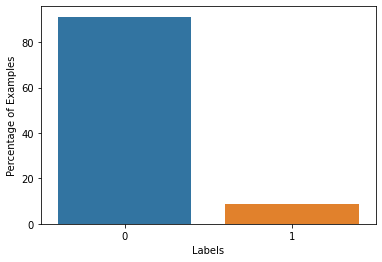

In [ ]:
ax = sns.barplot(x="Ground_Truth", y="Ground_Truth", data= training_df, estimator=lambda x: len(x) / len(training_df) * 100)
ax.set(ylabel="Percentage of Examples")
ax.set(xlabel="Labels")

[Text(0.5, 0, 'Labels')]

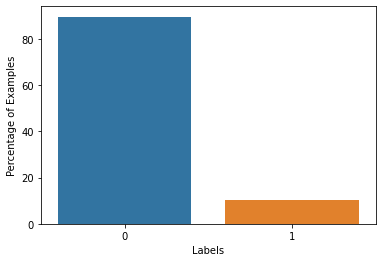

In [ ]:
ax = sns.barplot(x="Ground_Truth", y="Ground_Truth", data= validation_df, estimator=lambda x: len(x) / len(validation_df) * 100)
ax.set(ylabel="Percentage of Examples")
ax.set(xlabel="Labels")

[Text(0.5, 0, 'Labels')]

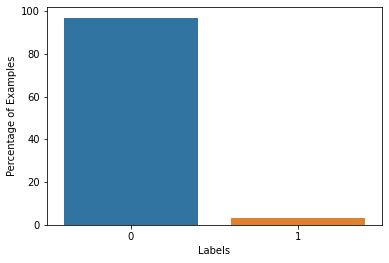

In [ ]:
ax = sns.barplot(x="Ground_Truth", y="Ground_Truth", data= testing_df, estimator=lambda x: len(x) / len(testing_df) * 100)
ax.set(ylabel="Percentage of Examples")
ax.set(xlabel="Labels")

2. Distribution of posts between users

In [ ]:
training_distribution = training_df.value_counts(subset=['Subject_IDS'])
print(training_distribution)

Subject_IDS
subject2472    1999
subject2419    1999
subject1195    1998
subject3232    1989
subject2129    1983
               ... 
subject2346      22
subject3883      17
subject3640      14
subject8720      12
subject2167      10
Length: 152, dtype: int64


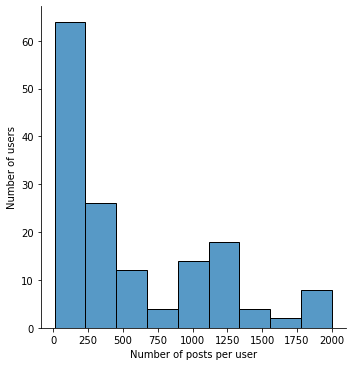

In [ ]:
ax = sns.displot(training_distribution)
ax.set(ylabel="Number of users")
ax.set(xlabel="Number of posts per user")

In [ ]:
validation_distribution = validation_df.value_counts(subset=['Subject_IDS'])
print(validation_distribution)

Subject_IDS
subject5614    1999
subject7478    1999
subject6790    1998
subject4244    1988
subject9950    1987
               ... 
subject4061      10
subject7483      10
subject6412      10
subject6472      10
subject4999      10
Length: 320, dtype: int64


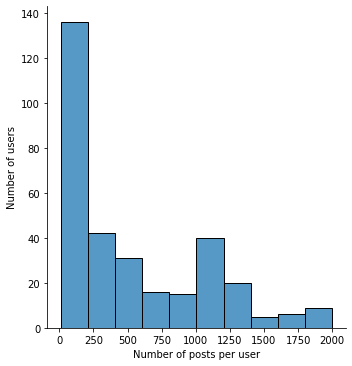

In [ ]:
ax = sns.displot(validation_distribution)
ax.set(ylabel="Number of users")
ax.set(xlabel="Number of posts per user")

In [ ]:
testing_distribution = testing_df.value_counts(subset=['Subject_IDS'])
print(testing_distribution)

Subject_IDS
subject9997    2000
subject4152    2000
subject7475    2000
subject1448    2000
subject5644    2000
               ... 
subject1158      10
subject7815      10
subject2624      10
subject798       10
subject6969      10
Length: 815, dtype: int64


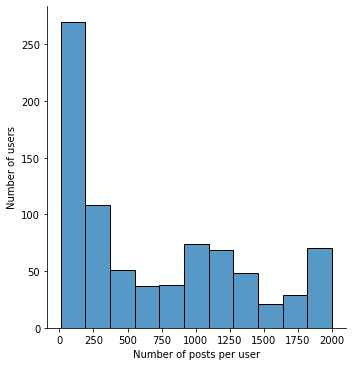

In [ ]:
ax = sns.displot(testing_distribution)
ax.set(ylabel="Number of users")
ax.set(xlabel="Number of posts per user")

3. Distribution of length of posts

In [ ]:
training_df["Comment_Length"]= training_df["Comments"].str.len()

In [ ]:
training_df

,Subject_IDS,XML_Paths,Ground_Truth,Comments,Comment_Length
0,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,Because he saw a movie once?,30.0
1,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,It's Canadian and was produced for dirt cheap...,170.0
2,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,World War Zimmerman and The Hobbit are probab...,288.0
3,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,dude you're the first person i've ever seen o...,261.0
4,subject1101,/content/drive/MyDrive/CIS_522_Project/eRisk20...,0,...\n\n...\n\n...\n\n...lol!,24.0
...,...,...,...,...,...
84830,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i couldn't find it,21.0
84831,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,im so convinced that i have cancer and I'm go...,278.0
84832,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,[removed],11.0
84833,subject5711,/content/drive/MyDrive/CIS_522_Project/eRisk20...,1,i LOVE being married \n\nbut i hate hate hate...,90.0


In [ ]:
training_df['Comment_Length'].describe()

count    84834.000000
mean       163.700026
std        489.822465
min          2.000000
25%         14.000000
50%         61.000000
75%        161.000000
max      39966.000000
Name: Comment_Length, dtype: float64

In [ ]:
validation_df["Comment_Length"]= validation_df["Comments"].str.len()

In [ ]:
validation_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth,Comment_Length
0,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
1,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
2,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
3,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
4,subject4556,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
...,...,...,...,...,...
168504,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
168505,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
168506,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0
168507,subject9225,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2.0


In [ ]:
validation_df['Comment_Length'].describe()

count    168507.000000
mean        160.385598
std         375.052536
min           2.000000
25%          20.000000
50%          66.000000
75%         166.000000
max       35245.000000
Name: Comment_Length, dtype: float64

In [ ]:
testing_df["Comment_Length"]= testing_df["Comments"].str.len()

In [ ]:
testing_df

,Subject_IDS,XML_Paths,Comments,Ground_Truth,Comment_Length
0,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Unfortunately no one is going to be able to t...,0,358
1,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's true. I was more talking about running...,0,238
2,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"To be honest, that could mean don't expect an...",0,245
3,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,That's pretty wild speculation. We don't know...,0,281
4,subject1183,/content/drive/MyDrive/CIS_522_Project/eRisk20...,Ehh you never know. I think we can still expe...,0,293
...,...,...,...,...,...
570504,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2
570505,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2
570506,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,,0,2
570507,subject9927,/content/drive/MyDrive/CIS_522_Project/eRisk20...,"And so we stagger forth, shuddering and reeli...",0,910


In [ ]:
testing_df['Comment_Length'].describe()

count    570509.000000
mean        157.244845
std         466.499518
min           2.000000
25%           5.000000
50%          53.000000
75%         149.000000
max      109027.000000
Name: Comment_Length, dtype: float64